# PetroFit Demo: PSF Sersic Fitting using Abell 2744

In [1]:
import warnings
import numpy as np

from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.utils.exceptions import AstropyWarning
from astropy.modeling import models

from photutils.segmentation import SourceCatalog 

In [2]:
# from petrofit.segmentation import make_catalog, plot_segments
# from petrofit.segmentation import make_segments, deblend_segments, plot_segments, get_source_position, masked_segm_image, get_source_ellip, get_source_theta
# from petrofit.models import PSFModel
# from petrofit.fitting import model_to_image, fit_model, plot_fit, print_model_params

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['image.origin'] = 'lower'

In [4]:
import ipywidgets as widgets
from IPython.display import display

DISPLAY_STYLE = {'description_width': 'initial'}

# Load Data

In [5]:
acs_filter_list = ['f435w', 'f606w', 'f814w']
wfc3_filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_{}-60mas_abell2744_{}_v1.0_drz.fits"

In [6]:
data_paths = {}
for f in acs_filter_list:
    data_paths[f] = input_data_formatter.format('acs', f)
    
for f in wfc3_filter_list:
    data_paths[f] = input_data_formatter.format('wfc3', f)
    
petrosian_cat_collection = {}

In [7]:
# Load data and vitals
# ---------------------

current_filter = 'f606w'
input_data_path = data_paths[current_filter]
#input_data_path = 'combined_data.fits'
data = CCDData.read(input_data_path, cache=True)

plt.imshow(data, vmin=0, vmax=data.data.std())

URLError: <urlopen error [SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:997)>

### Estimate data noise at dark area

-0.00012860226 0.0038543560076504946 0.010278282687067986


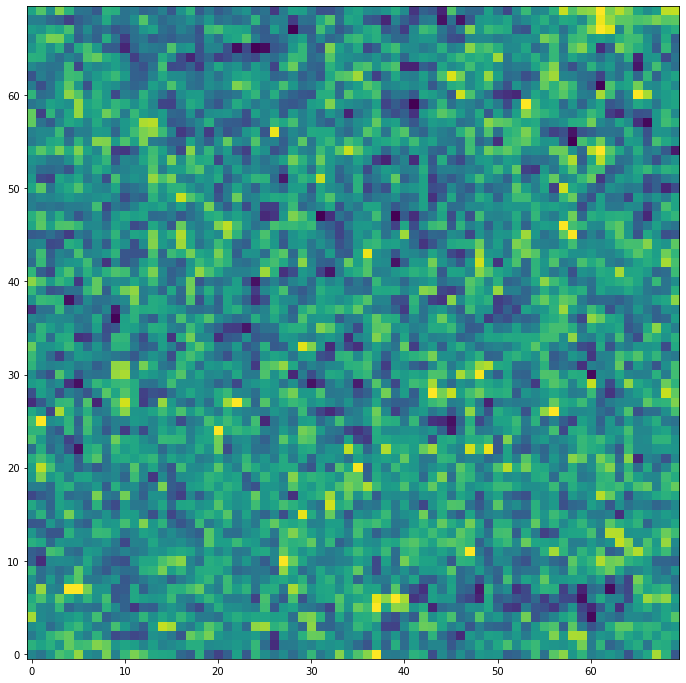

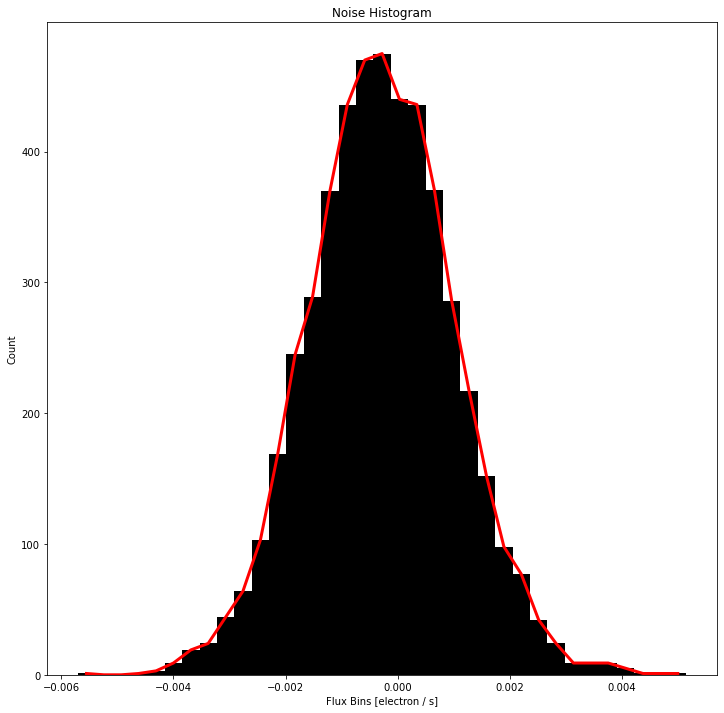

In [8]:
# Estimate data noise at dark area
# --------------------------------
noise_cutout = Cutout2D(data, (2760, 3420), 70)

noise_mean = noise_cutout.data.mean()
noise_sigma = noise_cutout.data.std()
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print(noise_mean, noise_3_sigma, noise_8_sigma)

plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
plt.show()

n, bins, patches = plt.hist(noise_cutout.data.flatten(), bins=35, align='left', color='black')
plt.plot(bins[:-1], n, c='r', linewidth=3)

plt.xlabel('Flux Bins [{}]'.format(str(data.unit)))
plt.ylabel('Count')
plt.title('Noise Histogram')
plt.show()

# PSF

In [ ]:
PSF = Cutout2D(data, (6759//2, 4102//2), 50+1).data

PSF = PSF / PSF.sum()

PSF_std = PSF.std()

print(PSF.min(), PSF.max(), PSF.mean())

plt.imshow(PSF, vmin=0, vmax=PSF_std/10)

# Target Image 

In [ ]:
# Cutout Image
# -------------

# Select and crop image:

cx, cy, size = 2083, 2859, 400 # Lone CD galaxy

image = Cutout2D(data, (cx, cy), size, copy=True)

# Compute image stats
image_min = image.data.min()
image_max = image.data.max()
image_mean = image.data.mean()
image_sigma = image.data.std()
image_3_sigma = image_sigma * 3.
image_8_sigma = image_sigma * 8.

image_clipped_mean, image_clipped_median, image_clipped_std = sigma_clipped_stats(image.data, sigma=3.0)

# Subtract Noise
#image.data  -= image_clipped_mean

# Set min and max values for all plots
vmin = -5 * image_clipped_std
vmax = +5 * image_clipped_std

plt.imshow(image.data, vmin=vmin, vmax=vmax)

print(image_mean)

# Segmentation (ID Target)

In [ ]:
# Catalog
# -------

# Define detect threshold
threshold = noise_8_sigma

# Define smoothing kernel
kernel_size = 5
fwhm = 5
npixels = 5**2


cat, segm, segm_deblend = make_catalog(
    image.data,
    threshold,
    deblend=True,
    kernel_size=kernel_size,
    fwhm=fwhm,
    npixels=npixels,
    plot=True, vmax=vmax, vmin=vmin
)

In [ ]:
result_cat = cat.to_table(cat.default_columns + ['maxval_xindex', 'maxval_yindex', 'ellipticity'] )
result_cat.sort(keys="area", reverse=1)

# Cutout Target and Zoom

In [ ]:
targ_idx = 0
mid = 150#
cutout_size = mid *2
row = result_cat[targ_idx]

x, y = [i for i in get_source_position(row)]

# Estimate mean in coutuout
target_zoom_nan_image = masked_segm_image(row['label'], image, segm_deblend, fill=np.nan, mask_background=False)
target_zoom_nan_image = Cutout2D(target_zoom_nan_image.data, (x, y), cutout_size, mode='partial', fill_value=np.nan)
mean, median, std = sigma_clipped_stats(target_zoom_nan_image.data, sigma=1.0, 
                                        mask=np.isnan(target_zoom_nan_image.data) 
                                       )


# Make coutuout
target_zoom = target_zoom_nan_image.data #- median 

target_zoom_raw_image = Cutout2D(image.data, (x, y), cutout_size, mode='partial', fill_value=np.nan, copy=True).data

masked_stats_image = target_zoom_nan_image.data
masked_image = target_zoom
sigma = 1
sigma_type = 'clip'

plt.imshow(target_zoom, vmin=vmin, vmax=vmax)

# AstroPy Model (No PSF)

In [ ]:
d = 5

sersic_model = models.Sersic2D(
        amplitude=1,
        r_eff=25,
        n=3.7,
        x_0=mid,
        y_0=mid,
        ellip=get_source_ellip(row), 
        theta=get_source_theta(row),
        bounds = {
            'amplitude': (0., None),
            'r_eff': (0, None),
            'n': (0, 10),
            'ellip': (0, 1),
            'theta': (-2*np.pi, 2*np.pi),
            'x_0': (mid-d, mid+d),
            'y_0': (mid-d, mid+d),
        },
)


### Fit AstroPy Model

In [ ]:
fitted_model, _ = fit_model(
    target_zoom, sersic_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

fitted_model_image = model_to_image(mid, mid, mid*2, fitted_model)

plt.imshow(target_zoom_raw_image-fitted_model_image, vmax=vmax, vmin=vmin)
plt.title("model_psf_image")
plt.show()


In [ ]:
plot_fit(target_zoom_raw_image, fitted_model, vmax=vmax, vmin=vmin);

# PetroFit PSFModel 

Wrap the fitted AstroPy model from the last step and add oversampling if needed. Oversampling of 2-4 is more than enough for an image 100 pix+.

In [ ]:
psf_model = PSFModel.wrap(fitted_model, psf=PSF, oversample=2)

# PSF rotation 
psf_model.bounds['psf_pa'] = (-5, 5)
psf_model.fixed['psf_pa'] = True # Do not rotate PSF 

In [ ]:
# PSF model 
psf_model

### Fit PSFModel Model

In [ ]:
fitted_psf_model, _ = fit_model(
    target_zoom, psf_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

fitted_psf_model_image = model_to_image(mid, mid, mid*2, fitted_psf_model)

plt.imshow(target_zoom_raw_image-fitted_psf_model_image, vmax=vmax, vmin=vmin)
plt.title("model_psf_image")
plt.show()


In [ ]:
plot_fit(target_zoom_raw_image, fitted_psf_model, vmax=vmax, vmin=vmin);

# Multi Object Fit

In [ ]:
# Cutout Image
# -------------

# Select and crop image:

cx, cy, size = 2864, 3563, 100 # Small faint group of galaxies

image = Cutout2D(data, (cx, cy), size, copy=True)

# Compute image stats
image_min = image.data.min()
image_max = image.data.max()
image_mean = image.data.mean()
image_sigma = image.data.std()
image_3_sigma = image_sigma * 3.
image_8_sigma = image_sigma * 8.

image_clipped_mean, image_clipped_median, image_clipped_std = sigma_clipped_stats(image.data, sigma=3.0)

# Subtract Noise
#image.data  -= image_clipped_mean

# Set min and max values for all plots
vmin = -5 * image_clipped_std
vmax = +5 * image_clipped_std

plt.imshow(image.data, vmin=vmin, vmax=vmax)

print(image_mean)

In [ ]:
# Catalog
# -------

# Catalog
# -------

# Define detect threshold
threshold = noise_8_sigma

# Define smoothing kernel
kernel_size = 5
fwhm = 5
npixels = 5**2


cat, segm, segm_deblend = make_catalog(
    image.data,
    threshold,
    deblend=True,
    kernel_size=kernel_size,
    fwhm=fwhm,
    npixels=npixels,
    plot=True, vmax=vmax, vmin=vmin
)

# Display source properties
print("Num of Targets:", len(cat))

plt.show()

In [ ]:
result_cat = cat.to_table(cat.default_columns + ['maxval_xindex', 'maxval_yindex', 'ellipticity'] )
result_cat.sort(keys="area", reverse=1)

target_zoom = image.data
target_zoom_raw_image = image.data
mid = target_zoom.shape[0]//2

In [ ]:
d = 10

row = result_cat[0]
sersic_model_1 = models.Sersic2D(
        amplitude=target_zoom.mean(),
        r_eff=10,
        n=1,
        x_0=get_source_position(row)[0],
        y_0=get_source_position(row)[1],
        ellip=get_source_ellip(row).value, 
        theta=get_source_theta(row).value,
        bounds = {
            'amplitude': (0., None),
            'r_eff': (0, None),
            'n': (0, 10),
            'ellip': (0, 1),
            'theta': (-2*np.pi, 2*np.pi),
            'x_0': (get_source_position(row)[0]-d, get_source_position(row)[0]+d),
            'y_0': (get_source_position(row)[1]-d, get_source_position(row)[1]+d),
        },
)

row = result_cat[1]
sersic_model_2 = models.Sersic2D(
        amplitude=target_zoom.mean(),
        r_eff=10,
        n=1,
        x_0=get_source_position(row)[0],
        y_0=get_source_position(row)[1],
        ellip=get_source_ellip(row).value, 
        theta=get_source_theta(row).value,
        bounds = {
            'amplitude': (0., None),
            'r_eff': (0, None),
            'n': (0, 10),
            'ellip': (0, 1),
            'theta': (-2*np.pi, 2*np.pi),
            'x_0': (get_source_position(row)[0]-d, get_source_position(row)[0]+d),
            'y_0': (get_source_position(row)[1]-d, get_source_position(row)[1]+d),
        },
)

row = result_cat[2]
sersic_model_3 = models.Sersic2D(
        amplitude=target_zoom.mean(),
        r_eff=10,
        n=1,
        x_0=get_source_position(row)[0],
        y_0=get_source_position(row)[1],
        ellip=get_source_ellip(row).value, 
        theta=get_source_theta(row).value,
        bounds = {
            'amplitude': (0., None),
            'r_eff': (0, None),
            'n': (0, 10),
            'ellip': (0, 1),
            'theta': (-2*np.pi, 2*np.pi),
            'x_0': (get_source_position(row)[0]-d, get_source_position(row)[0]+d),
            'y_0': (get_source_position(row)[1]-d, get_source_position(row)[1]+d),
        },
)

row = result_cat[3]
sersic_model_4 = models.Sersic2D(
        amplitude=target_zoom.mean(),
        r_eff=10,
        n=1,
        x_0=get_source_position(row)[0],
        y_0=get_source_position(row)[1],
        ellip=get_source_ellip(row).value, 
        theta=get_source_theta(row).value,
        bounds = {
            'amplitude': (0., None),
            'r_eff': (0, None),
            'n': (0, 10),
            'ellip': (0, 1),
            'theta': (-2*np.pi, 2*np.pi),
            'x_0': (get_source_position(row)[0]-d, get_source_position(row)[0]+d),
            'y_0': (get_source_position(row)[1]-d, get_source_position(row)[1]+d),
        },
)

row = result_cat[4]
sersic_model_5 = models.Sersic2D(
        amplitude=target_zoom.mean(),
        r_eff=10,
        n=1,
        x_0=get_source_position(row)[0],
        y_0=get_source_position(row)[1],
        ellip=get_source_ellip(row).value, 
        theta=get_source_theta(row).value,
        bounds = {
            'amplitude': (0., None),
            'r_eff': (0, None),
            'n': (0, 10),
            'ellip': (0, 1),
            'theta': (-2*np.pi, 2*np.pi),
            'x_0': (get_source_position(row)[0]-d, get_source_position(row)[0]+d),
            'y_0': (get_source_position(row)[1]-d, get_source_position(row)[1]+d),
        },
)

row = result_cat[5]
sersic_model_6 = models.Sersic2D(
        amplitude=target_zoom.mean(),
        r_eff=5,
        n=1,
        x_0=get_source_position(row)[0],
        y_0=get_source_position(row)[1],
        ellip=get_source_ellip(row).value, 
        theta=get_source_theta(row).value,
        bounds = {
            'amplitude': (0., None),
            'r_eff': (0, None),
            'n': (0, 10),
            'ellip': (0, 1),
            'theta': (-2*np.pi, 2*np.pi),
            'x_0': (get_source_position(row)[0]-d, get_source_position(row)[0]+d),
            'y_0': (get_source_position(row)[1]-d, get_source_position(row)[1]+d),
        },
)

psf_model = PSFModel.wrap(
    sersic_model_1 + sersic_model_2 + sersic_model_3 + sersic_model_4 + sersic_model_5 + sersic_model_6,
    psf=PSF, 
    oversample=2,
)

psf_model.fixed['psf_pa'] = True # No PSF rotation 

In [ ]:
%%time

# Usually takes 3 min or less:
fitted_psf_model, _ = fit_model(
    target_zoom, psf_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

In [ ]:
fitted_psf_model_image = model_to_image(mid, mid, mid*2, fitted_psf_model)

plt.imshow(target_zoom_raw_image, vmax=vmax, vmin=vmin)
plt.title("Original Image")
plt.show()

plt.imshow(fitted_psf_model_image , vmax=vmax, vmin=vmin)
plt.title("Model Image")
plt.show()

plt.imshow(target_zoom_raw_image-fitted_psf_model_image, vmax=vmax, vmin=vmin)
plt.title("Residual Image")
plt.show()


In [ ]:
print_model_params(fitted_psf_model)